In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from functions import plot_confusion_matrix
import lightgbm as lgb
import matplotlib as plt
%matplotlib inline

### lgb多分类

In [4]:
train = pd.read_csv('outdata/train_mult.csv')
train['label'].fillna(0,inplace=True)
test = pd.read_csv('outdata/test_mult.csv')
train.shape,test.shape

((491054, 401), (92571, 400))

In [5]:
def f1_score_vail(y_prtmped,data_vail):
    labels = data_vail.get_label()
    f1_list = f1_score(labels,np.argmax(y_prtmped.reshape(12, -1), axis=0),average='weighted')  
    return 'f1_score', f1_list, True

In [6]:
# lgb 参数
lgb_params = {
    "learning_rate": 0.05,
    "lambda_l1": 0.1,
    "lambda_l2": 0.2,
    "max_depth": 7,
    "num_leaves": 80,
    "objective": "multiclass",
    "num_class": 12,
    "verbose": -1,
    'feature_fraction': 0.8,
    "min_split_gain": 0.1,
    "boosting_type": "gbdt",
    "subsample": 0.8,
    "min_data_in_leaf": 50,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.7,
    "tree_method": 'exact'
}
skf = StratifiedKFold(n_splits=5, random_state=2018, shuffle=True)

index: 0


/home/cwl/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.889784	training's f1_score: 0.670333	valid_1's multi_logloss: 0.931672	valid_1's f1_score: 0.662367
[200]	training's multi_logloss: 0.84019	training's f1_score: 0.678595	valid_1's multi_logloss: 0.906382	valid_1's f1_score: 0.664945
[300]	training's multi_logloss: 0.814401	training's f1_score: 0.685181	valid_1's multi_logloss: 0.903018	valid_1's f1_score: 0.665518
[400]	training's multi_logloss: 0.790271	training's f1_score: 0.691956	valid_1's multi_logloss: 0.90202	valid_1's f1_score: 0.666
[500]	training's multi_logloss: 0.766388	training's f1_score: 0.699735	valid_1's multi_logloss: 0.901649	valid_1's f1_score: 0.666348
[600]	training's multi_logloss: 0.744165	training's f1_score: 0.707237	valid_1's multi_logloss: 0.902	valid_1's f1_score: 0.666565
Early stopping, best iteration is:
[503]	training's multi_logloss: 0.765707	training's f1_score: 0.699938	valid_1's multi_logloss: 0.901638	v

KeyboardInterrupt: 

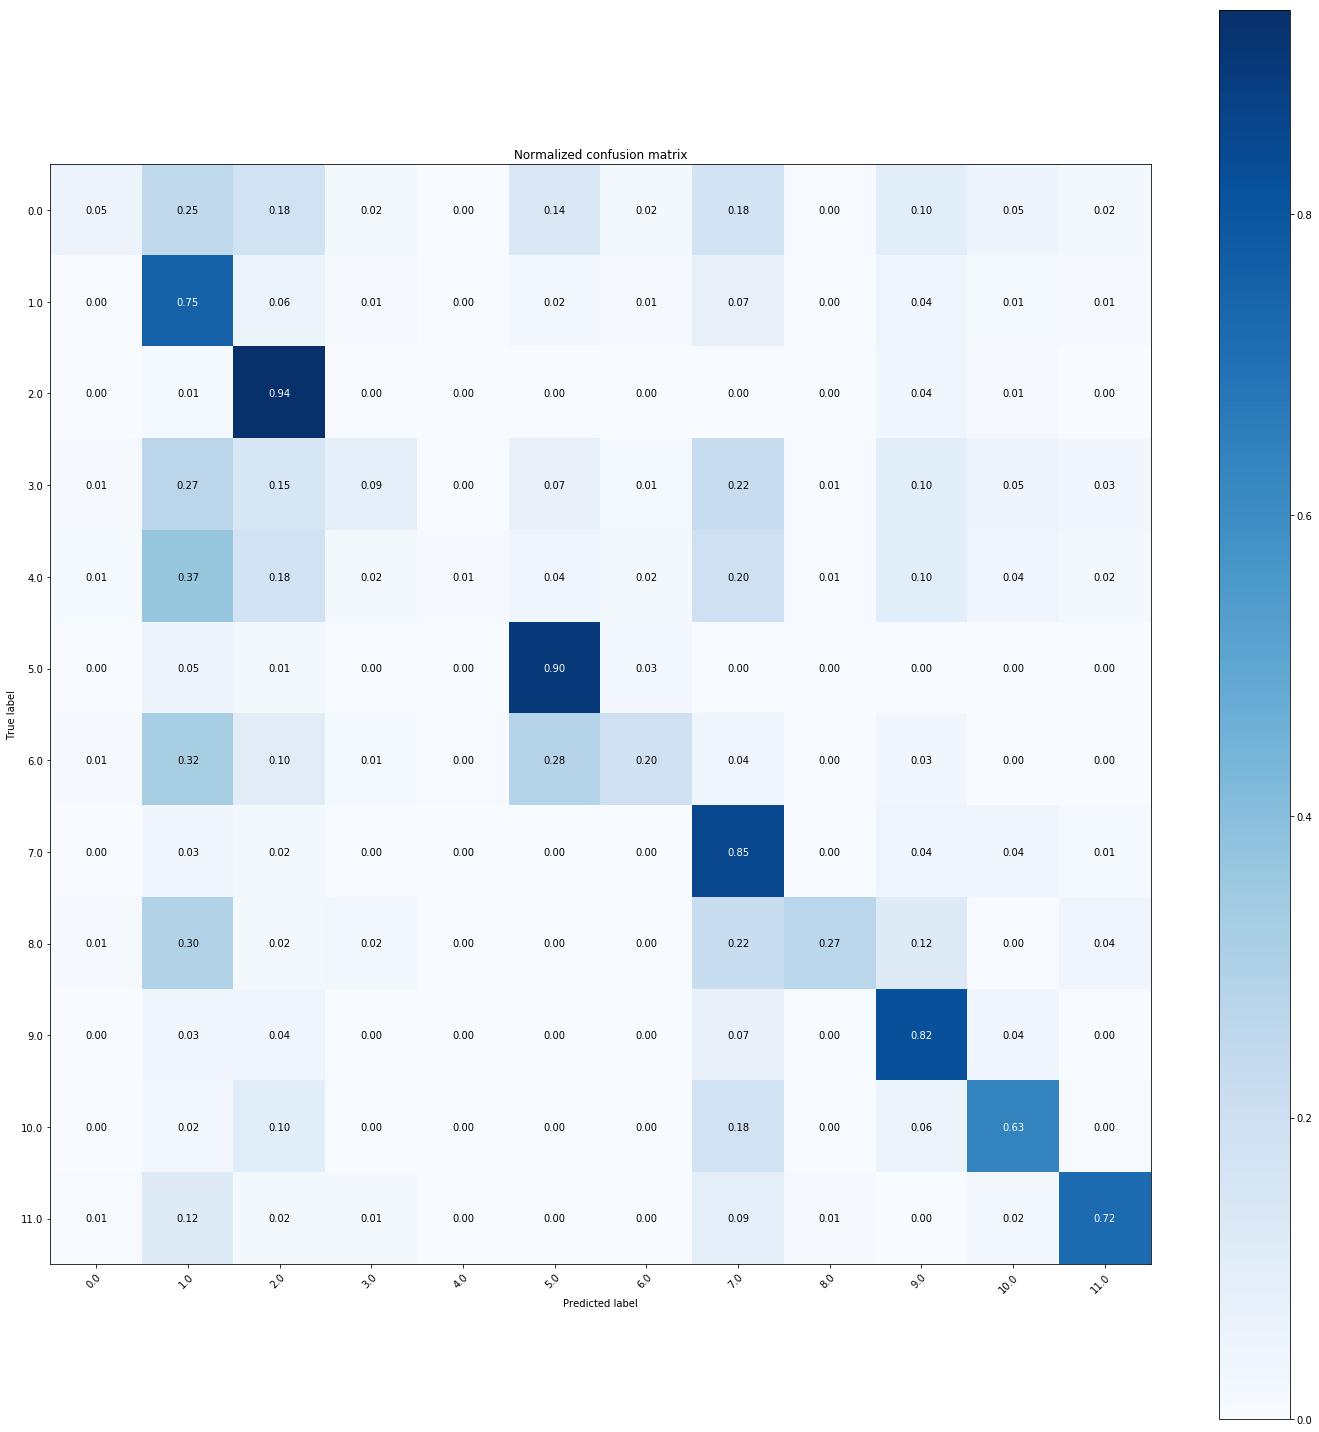

In [7]:
X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]
f1_values = []
for index, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    print('index:',index)
    train_lgb_data = lgb.Dataset(X_train.iloc[train_index], label=y_train.iloc[train_index])
    validation_lgb_data = lgb.Dataset(X_train.iloc[test_index], label=y_train.iloc[test_index])
    
    clf = lgb.train(lgb_params, 
                    train_lgb_data,
                    feval=f1_score_vail,
                    num_boost_round=1000, 
                    valid_sets=[train_lgb_data, validation_lgb_data],
                    early_stopping_rounds=100,
                    verbose_eval=100)
    f1_values.append(clf.best_score['valid_1']['f1_score'])
    print('f1_values:\n',f1_values)
    
    #验证集混淆矩阵
    y_valid = clf.predict(X_train.iloc[test_index],num_iteration=clf.best_iteration)
    y_valid = [np.argmax(x) for x in y_valid]
    plot_confusion_matrix(y_train.iloc[test_index].values, y_valid, classes_name=np.sort(train['label'].unique()), normalize=True,
                      title='Normalized confusion matrix')
    
    #预测集
    y_test = clf.predict(test, num_iteration=clf.best_iteration)  # 预测
    if index == 0:
        test_preDF = pd.DataFrame(y_test,index=test['sid'].values)
    else:
        test_preDF = pd.concat([test_preDF,pd.DataFrame(y_test,index=test['sid'].values)],axis=0)

In [ ]:
test_pred = test_preDF.reset_index().groupby('index').mean()

In [ ]:
#多分类后处理
proces_model = [2,1,7,4,3,6]
proces_weight = [0.9,0.8,0.8,3,3,2]
for i in range(len(proces_model)):
    test_pred.loc[:,proces_model[i]] = test_pred[proces_model[i]]* proces_weight[i]

In [ ]:
#多分类预测结果
mult_pred = pd.DataFrame()
for i in  range(1,12):
    tmp = test_pred[[i]].rename(columns={i:'mult_pred'})
    tmp['transport_mode'] = [i]*test_pred.shape[0]
    mult_pred = pd.concat([mult_pred,tmp],axis=0)
    print(mult_pred.shape)
mult_pred = mult_pred.reset_index().rename(columns={'index':'sid'})
mult_pred

In [ ]:
#多分类预测结果输出
mode_re = pd.DataFrame(index=test['sid'].values)
mode_re['pred_mode'] =test_pred.apply(lambda x:np.argmax(x.values),axis=1)
mode_re

In [ ]:
mode_re['pred_mode'] .value_counts().plot(kind='bar')

In [ ]:
#特征重要性分析
lgb.plot_importance(clf, figsize=(50, 50))  # 画出重要特征
# plt.title("Feature_importance")
plt.show()

### lgb二分类

In [39]:
train_bi = pd.read_csv('outdata/train.csv')
test_bi = pd.read_csv('outdata/test.csv')
train_bi.shape,test_bi.shape

((2276822, 125), (429803, 124))

In [73]:
#lgb 参数
lgb_model = lgb.LGBMClassifier(boosting_type='gbdt', 
                               num_leaves=80, 
                               reg_alpha=3, 
                               reg_lambda=5, 
                               max_depth=-1,
                               n_estimators=1000, 
                               objective='binary', 
                               subsample=0.9, 
                               colsample_bytree=0.77, 
                               subsample_freq=1, 
                               learning_rate=0.1,
                               random_state=1000, 
                               n_jobs=8, 
                               min_child_weight=4, 
                               min_child_samples=5, 
                               min_split_gain=0.1) 
fold_num = 5
skf = StratifiedKFold(n_splits=fold_num, random_state=2018, shuffle=True)

In [ ]:
def f1_valid(valid_df,y_valid):
    #without post processing
    valid_tmp = valid_df.copy()
    valid_tmp['pre_label'] = y_valid
    valid_tmp['pre_label_order'] = valid_tmp.groupby('sid')['pre_label'].rank(method='min',ascending=False)
    valid_true = valid_tmp[valid_tmp['label']==1]['transport_mode']
    valid_pred = valid_tmp[valid_tmp['pre_label_order']==1]['transport_mode']
    f1_value_1 = f1_score(valid_true.values,valid_pred.values)
    mat = plot_confusion_matrix(valid_true.values, valid_pred.values, classes_name=np.sort(valid_true.unique()), normalize=True,
                      title='Normalized confusion matrix')
    return f1_value_1

flod_num:0
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.919098	valid_0's binary_logloss: 0.438701
[200]	valid_0's auc: 0.920017	valid_0's binary_logloss: 0.436724
[300]	valid_0's auc: 0.920432	valid_0's binary_logloss: 0.435793
[400]	valid_0's auc: 0.920773	valid_0's binary_logloss: 0.435069
[500]	valid_0's auc: 0.920954	valid_0's binary_logloss: 0.434657
[600]	valid_0's auc: 0.921097	valid_0's binary_logloss: 0.434479
[700]	valid_0's auc: 0.921191	valid_0's binary_logloss: 0.434246
[800]	valid_0's auc: 0.921269	valid_0's binary_logloss: 0.434069
[900]	valid_0's auc: 0.921321	valid_0's binary_logloss: 0.433948
[1000]	valid_0's auc: 0.921342	valid_0's binary_logloss: 0.433879
Did not meet early stopping. Best iteration is:
[992]	valid_0's auc: 0.921345	valid_0's binary_logloss: 0.433853
auc_value:
 [0.9213445758744542]
Normalized confusion matrix
[[7.59769788e-01 4.96660509e-02 1.15105869e-02 3.33949126e-03
  2.56501350e-02 1.25053290e-02 6.92056

f1_score:
 [(0.5662764812635385, 0), (0.5652957336004565, 0), (0.5630367803823738, 0)]
flod_num:3
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.919357	valid_0's binary_logloss: 0.438332
[200]	valid_0's auc: 0.920359	valid_0's binary_logloss: 0.43616
[300]	valid_0's auc: 0.920714	valid_0's binary_logloss: 0.435296
[400]	valid_0's auc: 0.92095	valid_0's binary_logloss: 0.434783
[500]	valid_0's auc: 0.921116	valid_0's binary_logloss: 0.434405
[600]	valid_0's auc: 0.921231	valid_0's binary_logloss: 0.434239
[700]	valid_0's auc: 0.921379	valid_0's binary_logloss: 0.43391
[800]	valid_0's auc: 0.921402	valid_0's binary_logloss: 0.433857
Early stopping, best iteration is:
[741]	valid_0's auc: 0.921429	valid_0's binary_logloss: 0.433836
auc_value:
 [0.9213445758744542, 0.9221769596228439, 0.9212831275293646, 0.9214292827472262]
Normalized confusion matrix
[[7.65454029e-01 4.73213017e-02 1.05868978e-02 2.77106722e-03
  2.42290749e-02 1.22921700e-02 6.69319

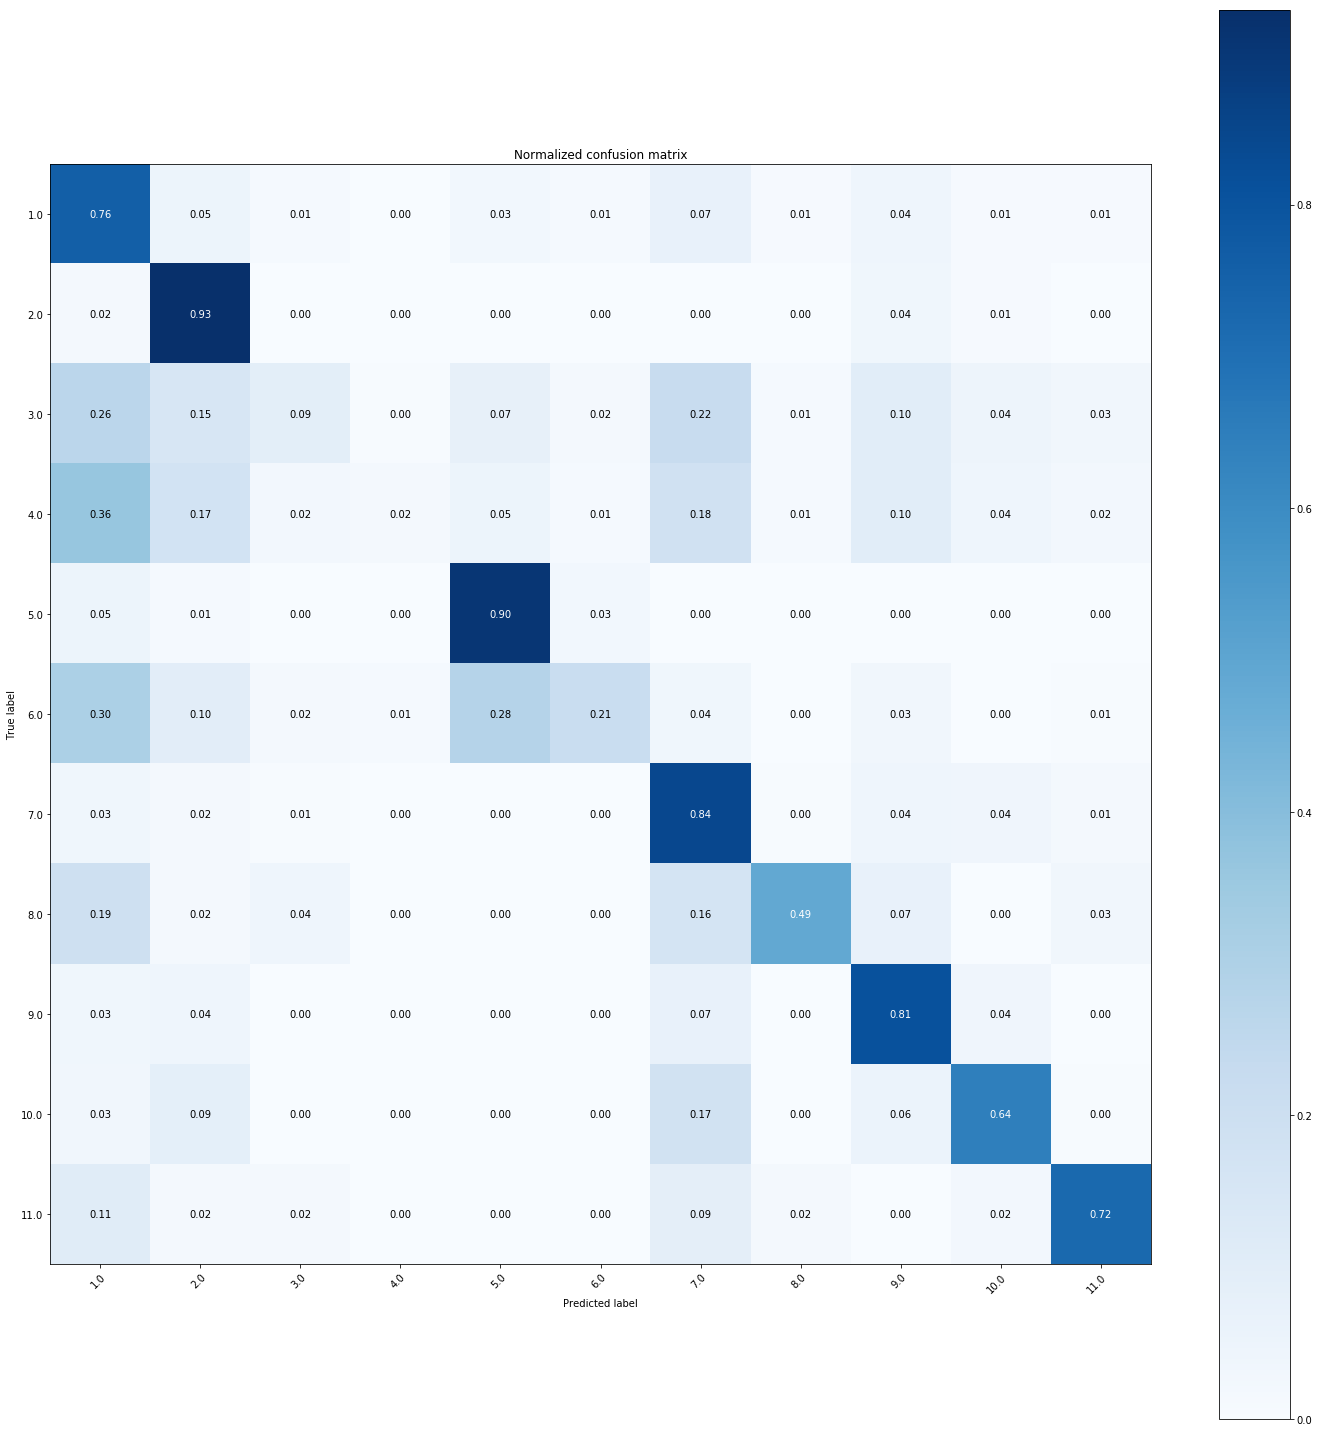

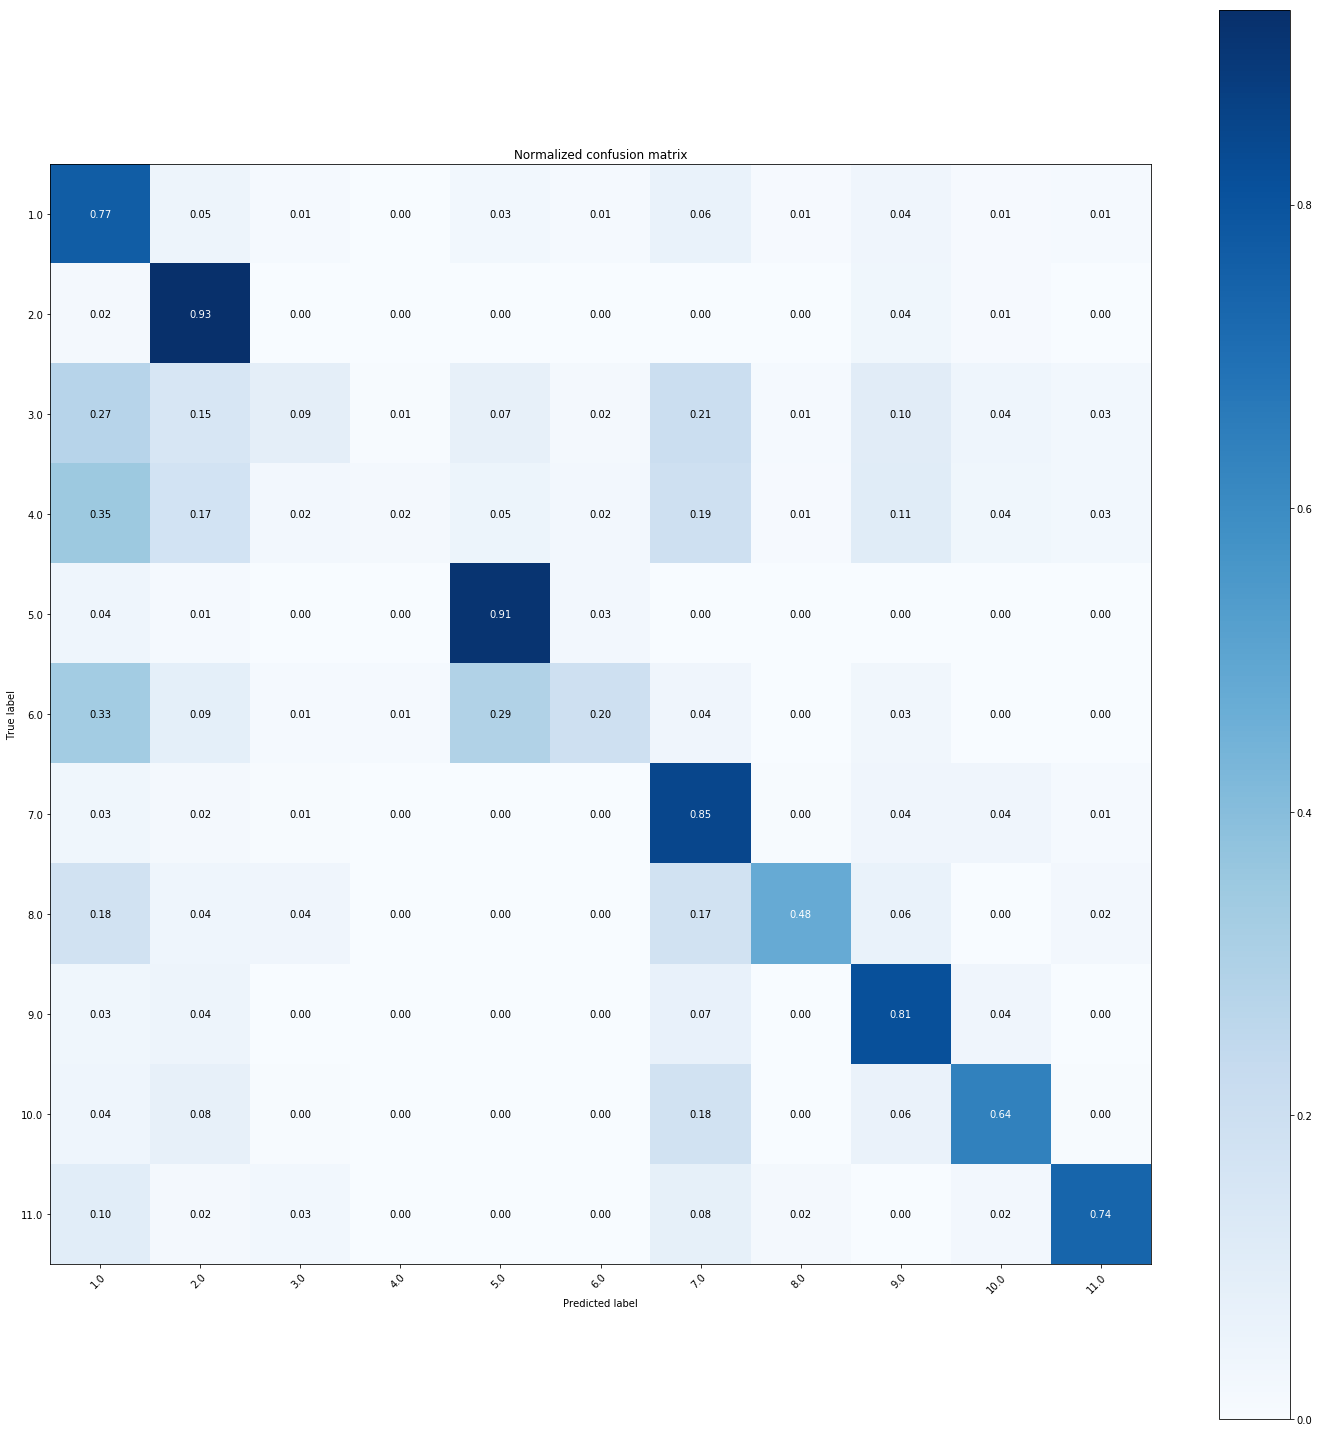

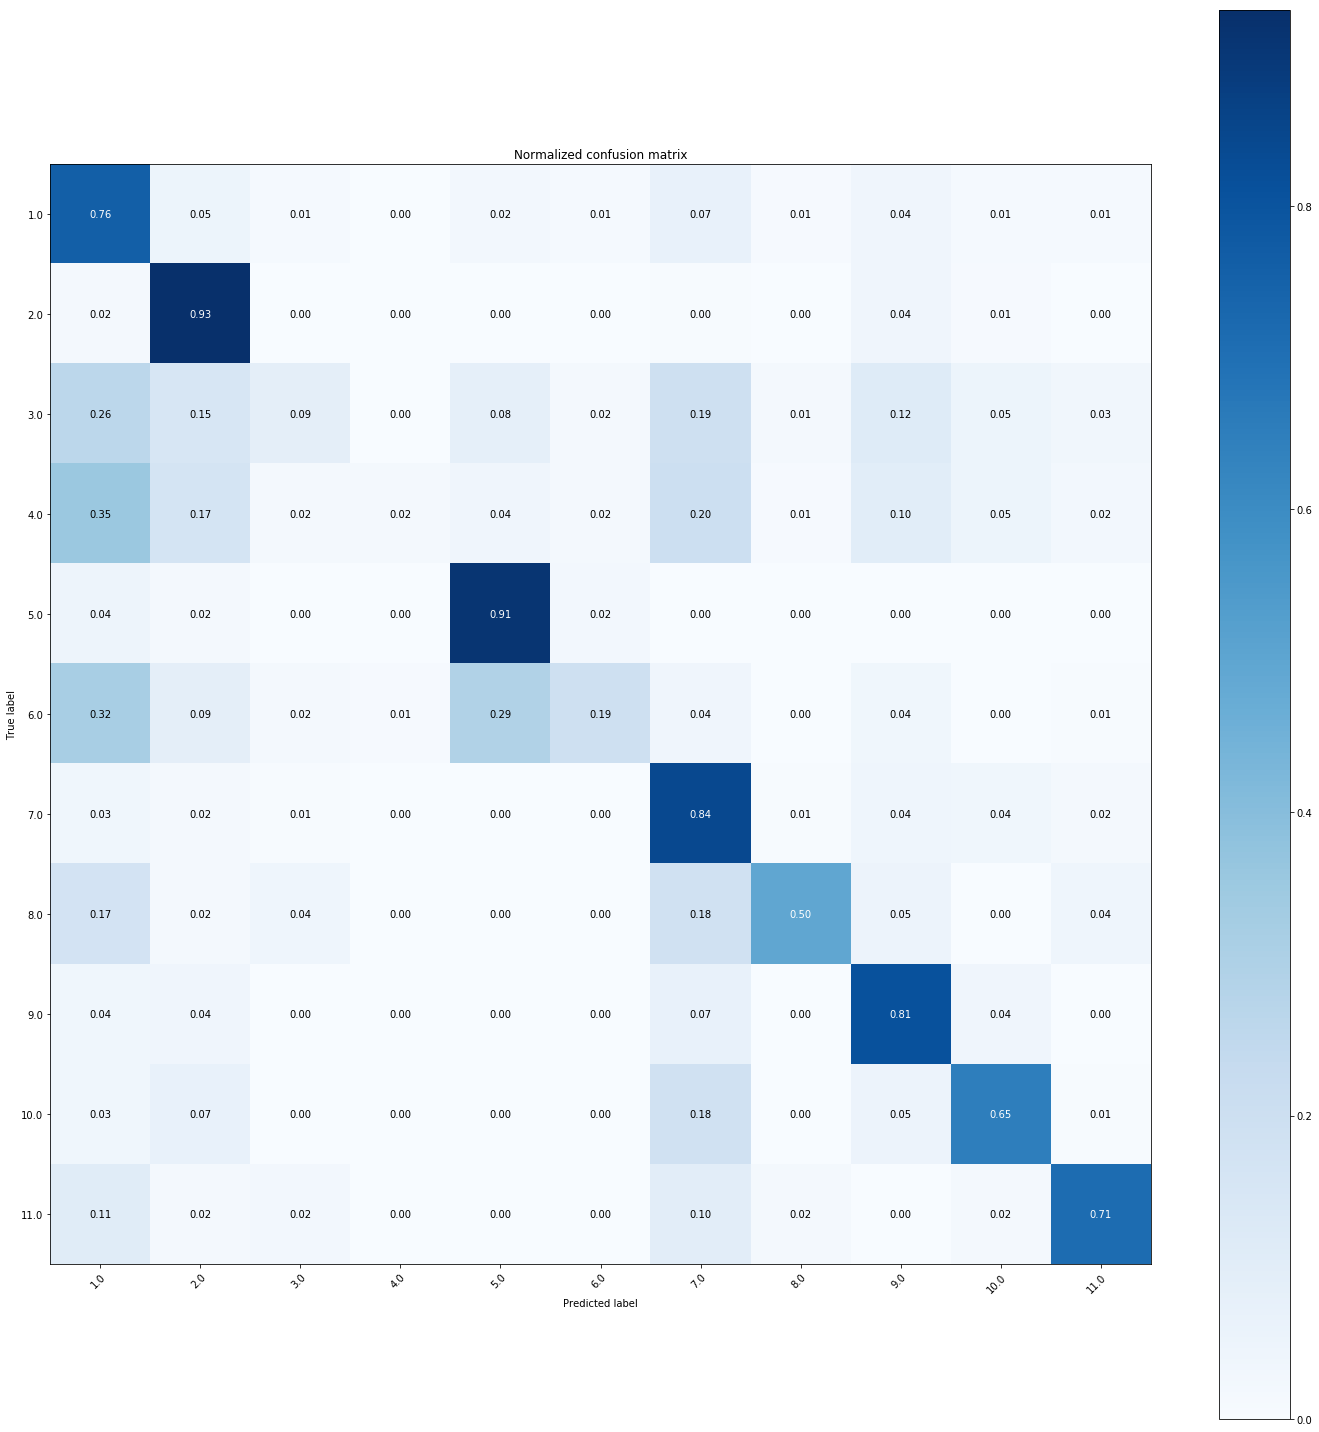

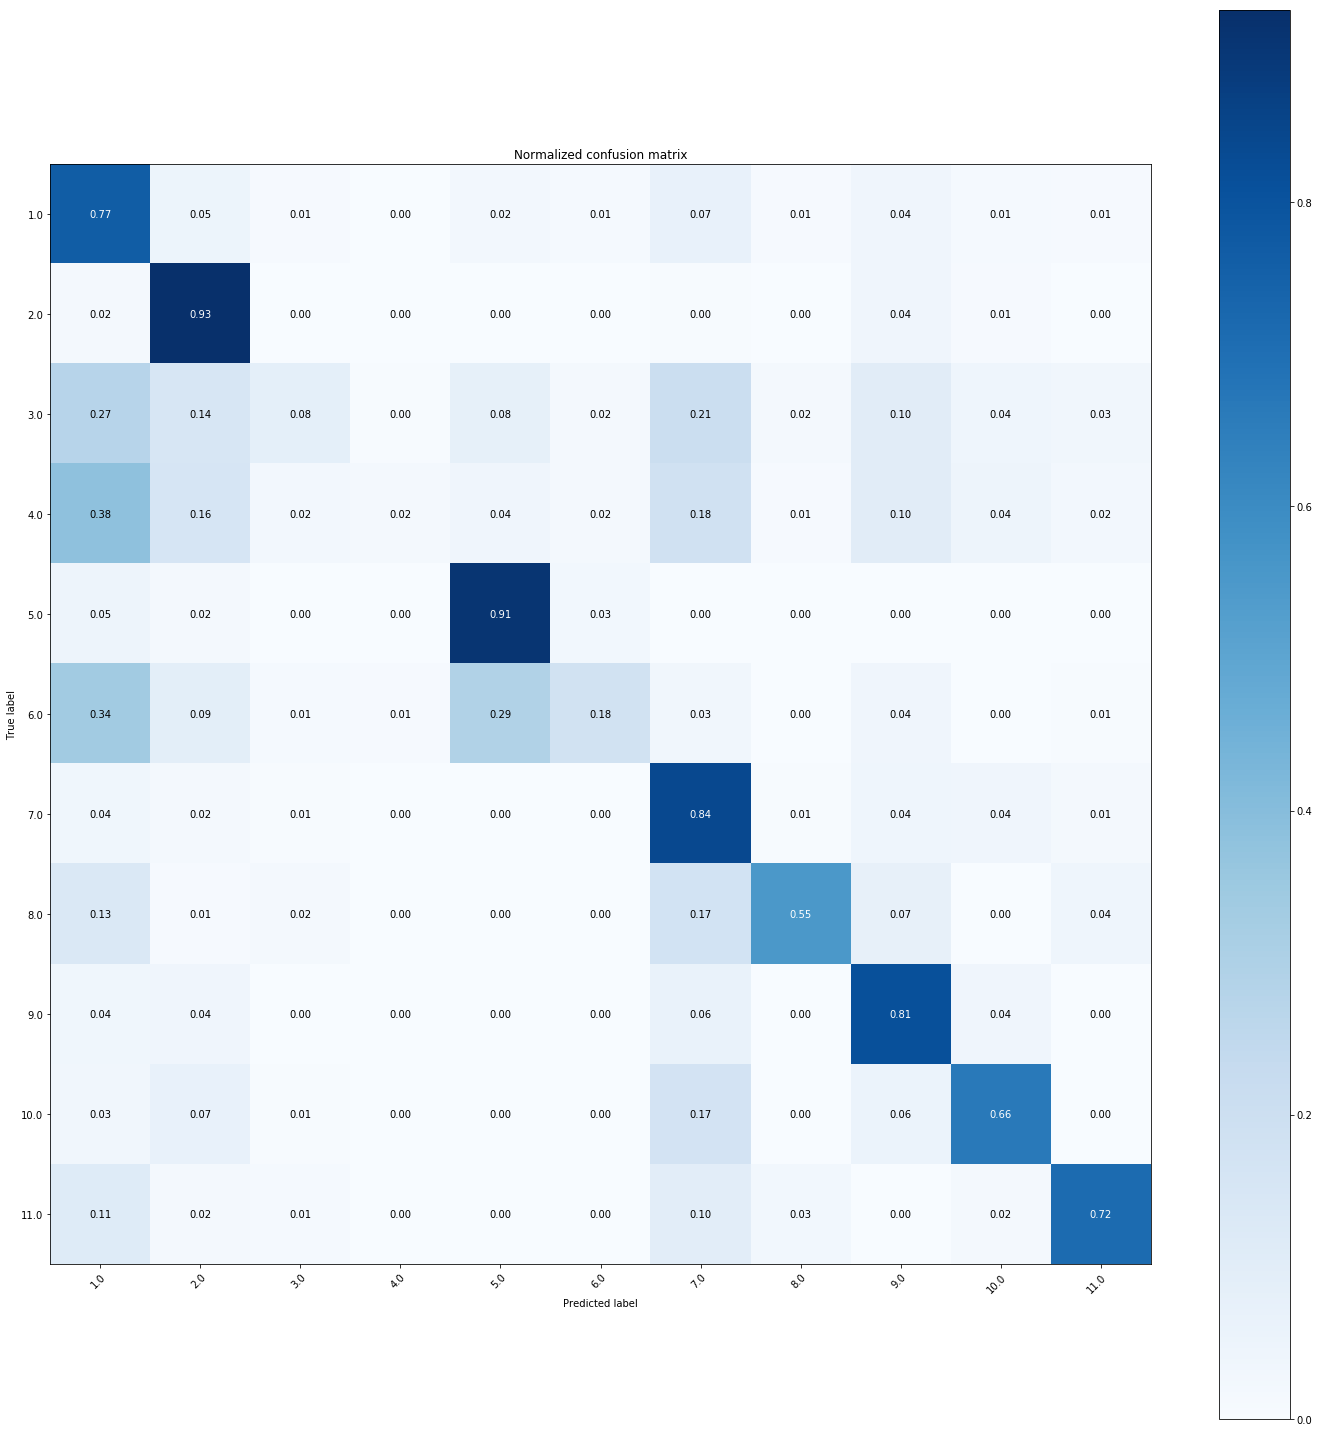

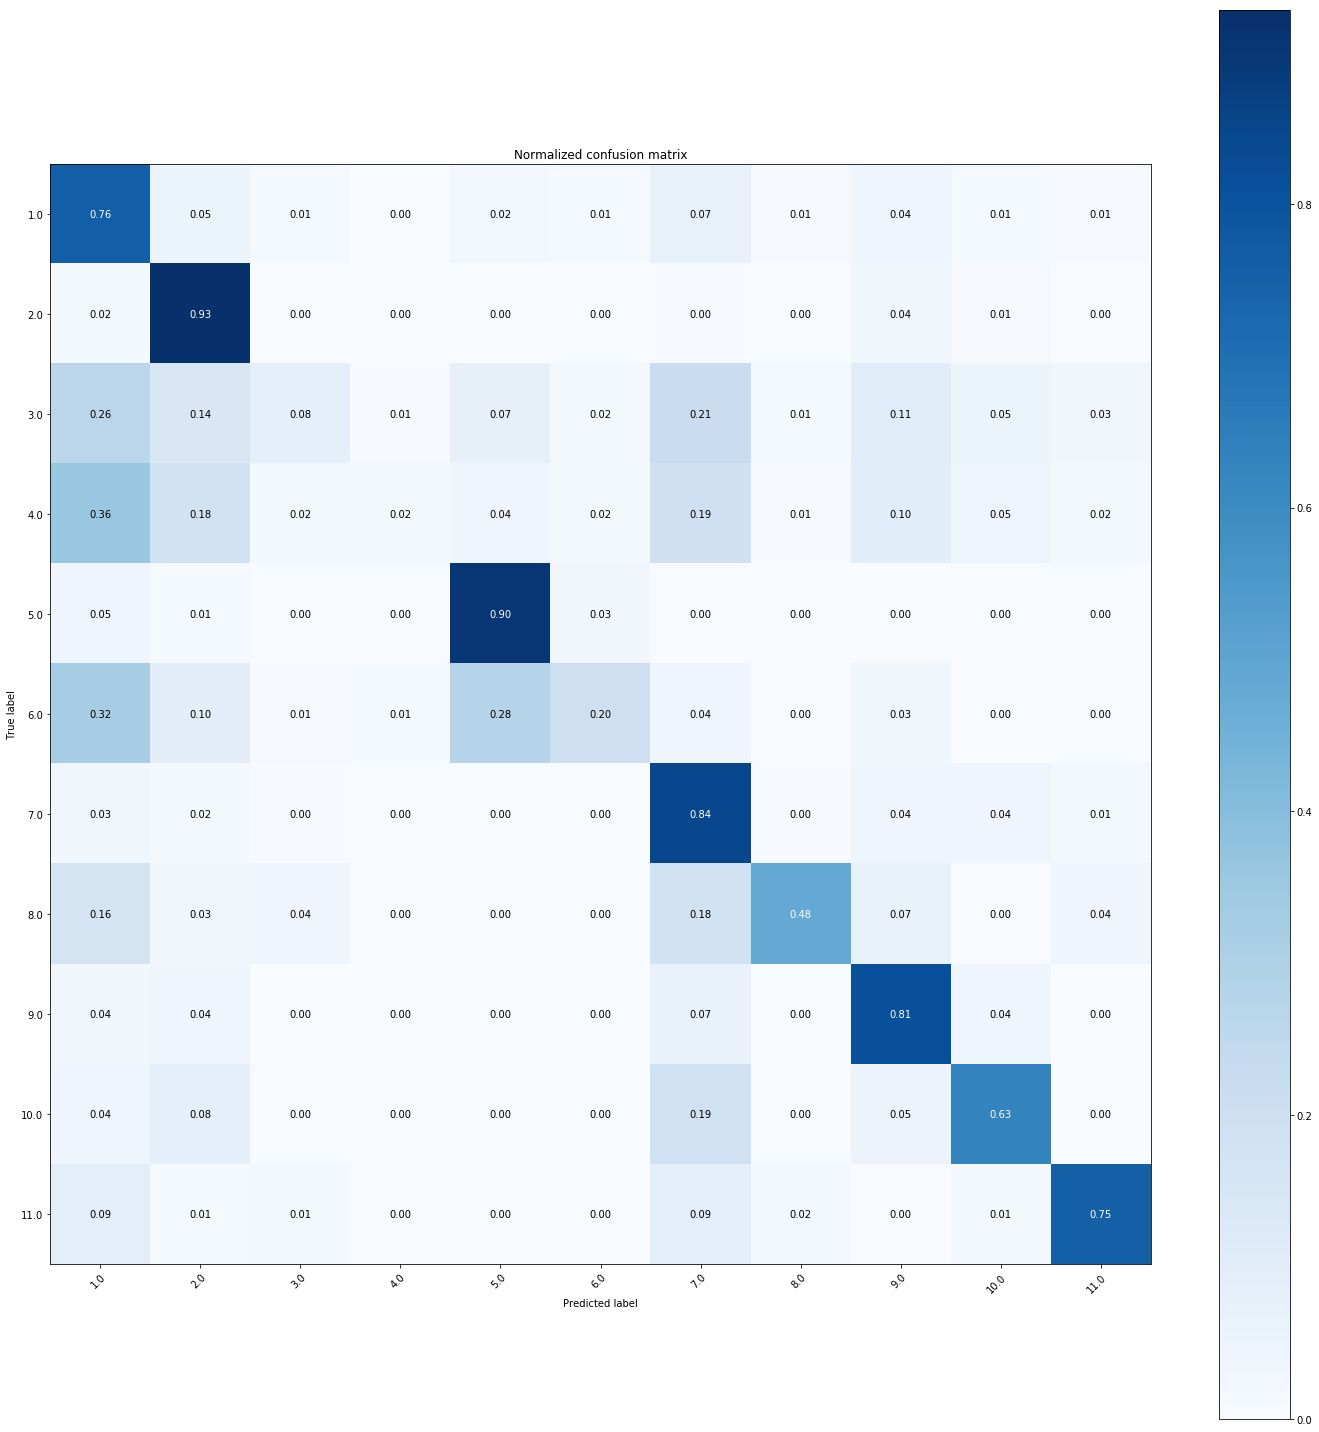

In [101]:
#以sid，transport_mode比例划分训练测试集
auc_value = []
f1_value = []
test_preds = np.zeros(test_bi.shape[0])
train_sub = train_bi[train_bi['label']==1][['sid','transport_mode']]
for index, (train_index, valid_index) in enumerate(skf.split(train_sub, train_sub['transport_mode'])):
    print("flod_num:%d" %index)  
    train_df = train_bi[train_bi['sid'].isin(train_sub.iloc[train_index,0].values)]
    valid_df = train_bi[train_bi['sid'].isin(train_sub.iloc[valid_index,0].values)]
    lgb_model.fit(train_df.iloc[:,:-1], train_df.iloc[:,-1], 
                  verbose=100,
                  eval_metric='auc',
                  eval_set=[(valid_df.iloc[:,:-1], valid_df.iloc[:,-1])],
                  early_stopping_rounds=100,
                  eval_class_weight=['balanced','balanced'])
    
    auc_value.append(lgb_model.best_score_['valid_0']['auc'])
    print('auc_value:\n',auc_value)
    
    #f1二分类验证
    y_valid = lgb_model.predict_proba(valid_df.iloc[:,:-1], num_iteration=lgb_model.best_iteration_)[:,1]
    f1_value.append(f1_valid(valid_df, y_valid))
    print("f1_score:\n",f1_value)
        
    #测试集预测
    y_test = lgb_model.predict_proba(test_bi, num_iteration=lgb_model.best_iteration_)[:, 1]
    test_preds += y_test / fold_num

In [176]:
#测试结果后处理 0423
testDF = test_bi[['sid','transport_mode']].copy()
testDF['bi_pred'] = pd.Series(y_test)
testDF

,sid,transport_mode,bi_pred
0,1126541,2.0,0.857792
1,1126541,3.0,0.019231
2,1126541,4.0,0.024095
3,1126541,9.0,0.192773
4,1126541,6.0,0.006420
5,1126541,7.0,0.052802
6,453685,1.0,0.666031
7,453685,6.0,0.122101
8,453685,3.0,0.009038
9,453685,4.0,0.051570


In [157]:
#测试结果后处理 0424
process_mode =[1,7,4,3,6]
process_weight = [0.8,0.8,3,3,2]
for i in range(len(process_mode)):
    testDF.loc[testDF[testDF['transport_mode']==process_mode[i]].index,'bi_pred'] = testDF['bi_pred']* process_weight[i]
testDF

,sid,transport_mode,bi_pred
0,1126541,2.0,0.857792
1,1126541,3.0,0.057694
2,1126541,4.0,0.072285
3,1126541,9.0,0.192773
4,1126541,6.0,0.012839
5,1126541,7.0,0.042241
6,453685,1.0,0.532825
7,453685,6.0,0.244201
8,453685,3.0,0.027113
9,453685,4.0,0.154711


In [87]:
#分组取概率最大的model
testDF['pre_label_order'] = testDF.groupby('sid')['pre_label'].rank(method='min',ascending=False)
test_out = testDF[testDF['pre_label_order']==1][['sid','transport_mode','pre_label','pre_label_order']]
test_out['transport_mode'].value_counts()

2.0     33520
7.0     20927
1.0     15721
5.0     10427
3.0      4573
10.0     3256
4.0      2080
9.0      1011
6.0       443
8.0       386
11.0      227
Name: transport_mode, dtype: int64

### 二分类与多分类结果融合

In [166]:
#二分类与多分类预测结果合并
final_pred = testDF.merge(mult_pred,how='left',on=['sid','transport_mode'])
final_pred['mode_pred'] = final_pred['bi_pred']+final_pred['mult_pred']
final_pred['pred_order'] = final_pred.groupby('sid')['mode_pred'].rank(method='min',ascending=False)
final_pred

,sid,transport_mode,bi_pred,mult_pred,mode_pred,pred_order
0,1126541,2.0,0.857792,0.794041,1.651833,1.0
1,1126541,3.0,0.057694,0.057403,0.115097,3.0
2,1126541,4.0,0.072285,0.040947,0.113232,4.0
3,1126541,9.0,0.192773,0.050892,0.243664,2.0
4,1126541,6.0,0.012839,0.010538,0.023377,6.0
5,1126541,7.0,0.042241,0.020867,0.063108,5.0
6,453685,1.0,0.532825,0.615510,1.148335,1.0
7,453685,6.0,0.244201,0.221556,0.465758,3.0
8,453685,3.0,0.027113,0.037451,0.064564,6.0
9,453685,4.0,0.154711,0.114808,0.269520,4.0


In [168]:
result = final_pred[final_pred['pred_order']==1][['sid','transport_mode']].rename(columns={'transport_mode':'recommend_mode'}).astype(int)
result.to_csv('submission/submission20190429_1.csv',index=None)
result['recommend_mode'].value_counts()

2     33723
7     21103
1     15586
5     10442
3      4372
10     3351
4      1856
9      1184
6       513
8       230
11      211
Name: recommend_mode, dtype: int64

In [179]:
pd.cut(mult_pred['mult_pred'],[x*0.1 for x in range(31)]).value_counts().sort_index()

(0.0, 0.1]    806387
(0.1, 0.2]     73237
(0.2, 0.3]     27488
(0.3, 0.4]     13648
(0.4, 0.5]     12850
(0.5, 0.6]     17019
(0.6, 0.7]     18812
(0.7, 0.8]     19932
(0.8, 0.9]     22112
(0.9, 1.0]      5897
(1.0, 1.1]       219
(1.1, 1.2]       142
(1.2, 1.3]       106
(1.3, 1.4]        85
(1.4, 1.5]        66
(1.5, 1.6]        64
(1.6, 1.7]        47
(1.7, 1.8]        30
(1.8, 1.9]        34
(1.9, 2.0]        15
(2.0, 2.1]        14
(2.1, 2.2]         7
(2.2, 2.3]         6
(2.3, 2.4]         5
(2.4, 2.5]         4
(2.5, 2.6]         3
(2.6, 2.7]         1
(2.7, 2.8]         6
(2.8, 2.9]        17
(2.9, 3.0]        28
Name: mult_pred, dtype: int64

In [ ]:
valid_tmp = valid_df.iloc[:,:-1]
y_valid = lgb_model.predict_proba(valid_tmp.iloc[:,:-1], num_iteration=lgb_model.best_iteration_)[:,1]
valid_tmp['pre_label'] = y_valid

In [82]:
# valid_tmp.loc[valid_tmp[valid_tmp['transport_mode']==1].index,'pre_label'] = valid_tmp['pre_label']*
valid_tmp.loc[valid_tmp[valid_tmp['transport_mode']==7].index,'pre_label'] = valid_tmp['pre_label']*0.8
valid_tmp.loc[valid_tmp[valid_tmp['transport_mode']==4].index,'pre_label'] = valid_tmp['pre_label']*3
valid_tmp.loc[valid_tmp[valid_tmp['transport_mode']==3].index,'pre_label'] = valid_tmp['pre_label']*3
valid_tmp.loc[valid_tmp[valid_tmp['transport_mode']==6].index,'pre_label'] = valid_tmp['pre_label']*2

Normalized confusion matrix
[[6.60910964e-01 4.64719676e-02 8.16457045e-02 5.16592056e-02
  1.71960492e-02 2.16016485e-02 6.08256946e-02 5.96887657e-03
  3.58132594e-02 9.87706957e-03 8.02956015e-03]
 [1.67777859e-02 9.24280167e-01 3.99296652e-03 3.95633380e-03
  1.64847242e-03 1.83163602e-03 4.06623196e-03 2.19796322e-04
  3.38120009e-02 9.04828193e-03 3.66327203e-04]
 [1.61421320e-01 1.35837563e-01 2.61522843e-01 4.75126904e-02
  5.84771574e-02 2.65989848e-02 1.54314721e-01 6.90355330e-03
  8.42639594e-02 4.20304569e-02 2.11167513e-02]
 [2.22134074e-01 1.66600555e-01 1.14240381e-01 1.49940500e-01
  1.66600555e-02 2.85600952e-02 1.55890520e-01 7.53669179e-03
  8.13169377e-02 4.16501388e-02 1.54700516e-02]
 [3.59098568e-02 1.22156698e-02 9.37236731e-03 1.95871946e-02
  8.74789385e-01 4.62299916e-02 8.42459983e-04 0.00000000e+00
  9.47767481e-04 0.00000000e+00 1.05307498e-04]
 [2.35666105e-01 9.14839798e-02 4.67959528e-02 9.82293423e-02
  2.19645868e-01 2.49578415e-01 2.78246206e-02 8.4

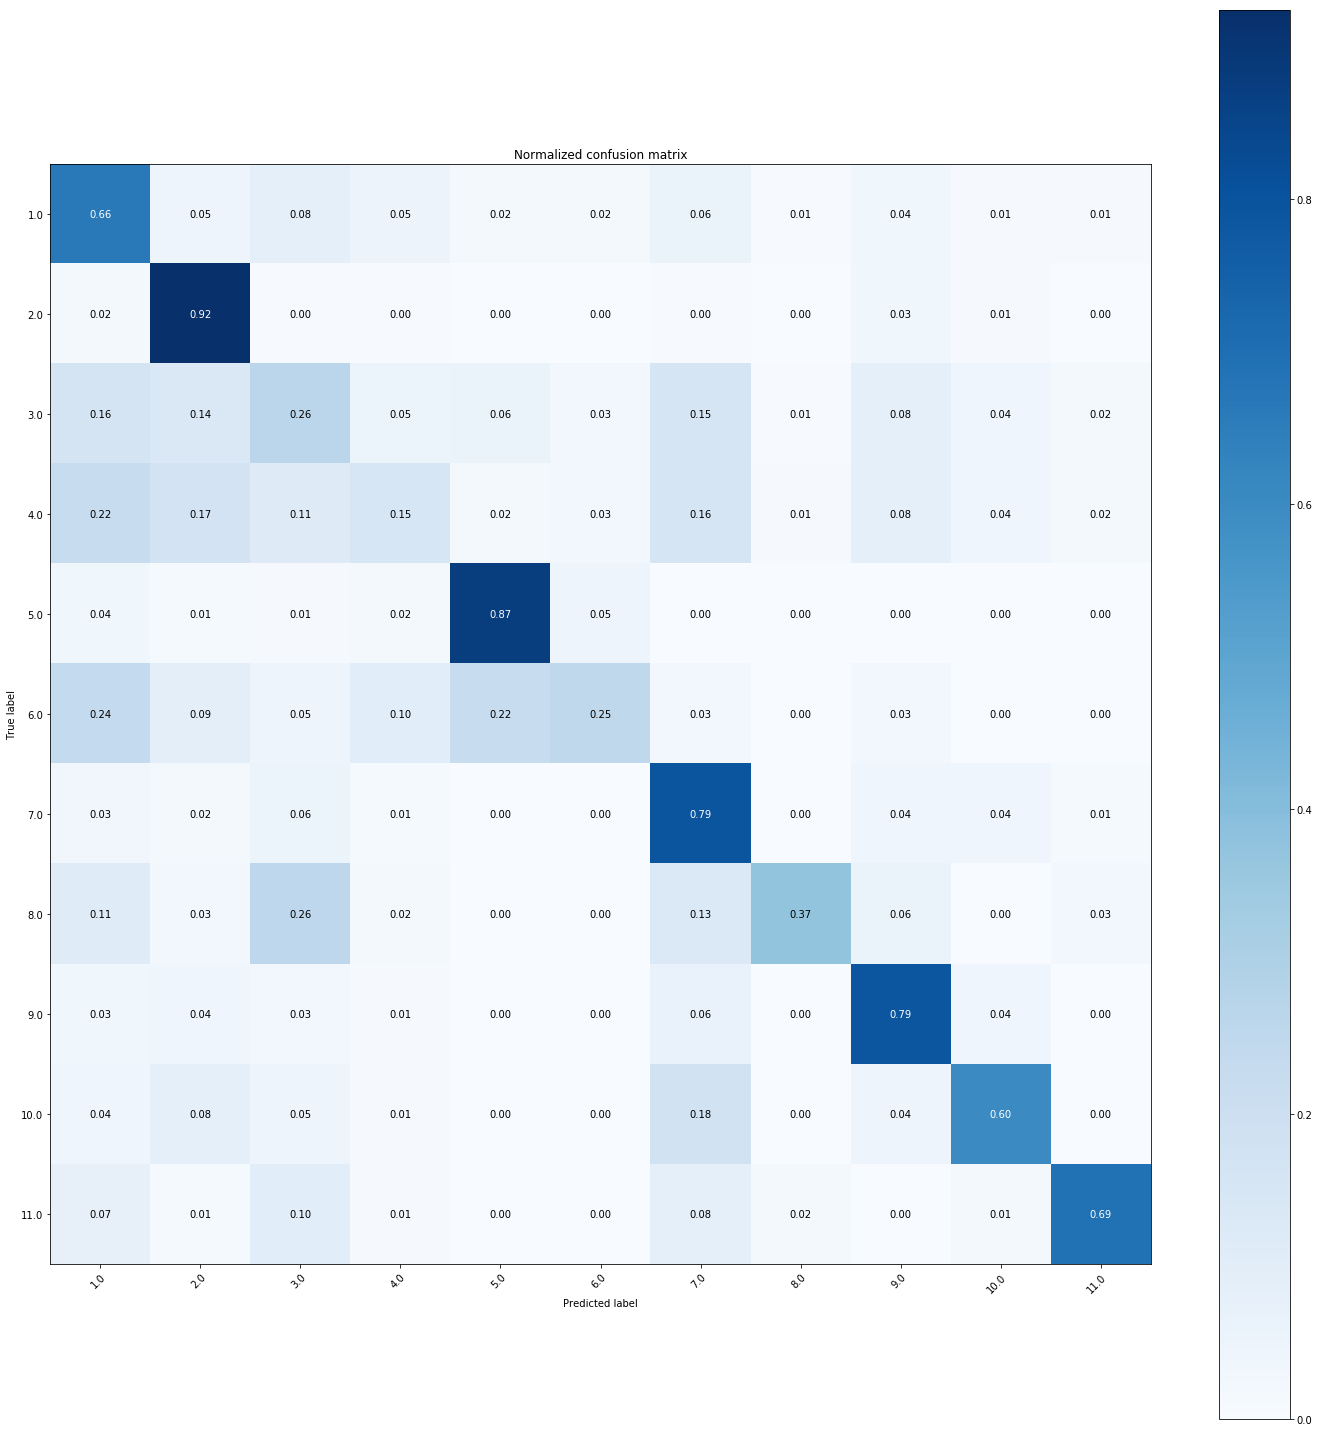

In [83]:
valid_tmp['pre_label_order'] = valid_tmp.groupby('sid')['pre_label'].rank(method='min',ascending=False)
valid_true = valid_tmp[valid_tmp['label']==1]['transport_mode']
valid_pred = valid_tmp[valid_tmp['pre_label_order']==1]['transport_mode']
mat = plot_confusion_matrix(valid_true.values, valid_pred.values, classes_name=np.sort(valid_true.unique()), normalize=True,
                      title='Normalized confusion matrix')

In [100]:
#自定义各类别f1权重
weights=test_bi['transport_mode'].value_counts().values
def multiclass_f1(y_true,y_pred,weights=weights):
    f1_list = f1_score(y_true,y_pred,average=None)
    f1_fina = np.sum(f1_list * weights) / weights.sum()
    return f1_fina

def f1_valid(valid_df,y_valid,post_process_flag=True):
    #without post processing
    valid_tmp = valid_df.copy()
    valid_tmp['pre_label'] = y_valid
    valid_tmp['pre_label_order'] = valid_tmp.groupby('sid')['pre_label'].rank(method='min',ascending=False)
    valid_true = valid_tmp[valid_tmp['label']==1]['transport_mode']
    valid_pred = valid_tmp[valid_tmp['pre_label_order']==1]['transport_mode']
    f1_value_1 = multiclass_f1(valid_true.values,valid_pred.values)
    mat = plot_confusion_matrix(valid_true.values, valid_pred.values, classes_name=np.sort(valid_true.unique()), normalize=True,
                      title='Normalized confusion matrix')
#     plt.show()
#     valid_pred.value_counts().sort_index().plot(kind='bar',title='valid_pre_model_1')
    
    #with post processing
    f1_value_2 = 0
#     if post_process_flag:
#         proces_model = [2,1,7,4,3,6]
#         proces_weight = [0.9,0.8,0.8,3,2,2]
#         for i in range(len(proces_model)):
#             valid_tmp.loc[valid_tmp[valid_tmp['transport_mode']==proces_model[i]].index,'pre_label'] = valid_tmp['pre_label']* proces_weight[i]
#         valid_tmp['pre_label_order'] = valid_tmp.groupby('sid')['pre_label'].rank(method='min',ascending=False)
#         valid_pred = valid_tmp[valid_tmp['pre_label_order']==1]['transport_mode']
#         f1_value_2 = multiclass_f1(valid_true.values,valid_pred.values）
#         mat = plot_confusion_matrix(valid_true.values, valid_pred.values, classes_name=np.sort(valid_true.unique()), normalize=True,
#                       title='Normalized confusion matrix with process')
#         plt.show()
#         valid_pred.value_counts().sort_index().plot(kind='bar',title='valid_pre_model_2')
    
    return (f1_value_1,f1_value_2)

In [64]:
# lgb 参数
lgb_params = {
    "learning_rate": 0.05,
    "lambda_l1": 0.1,
    "lambda_l2": 0.2,
    "max_depth": 7,
    "num_leaves": 80,
    "objective": "binary",
    "verbose": -1,
    'feature_fraction': 0.8,
    "min_split_gain": 0.1,
    "boosting_type": "gbdt",
    "subsample": 0.8,
    "min_data_in_leaf": 50,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.7,
    "tree_method": 'exact'
}

In [66]:
def f1_score_vail(y_prtmped,data_vail):
    labels = data_vail.get_label()
    print(len(labels),len(y_prtmped))
    print(y_prtmped)
    f1_list = f1_score(labels,y_prtmped,average='weighted')  
    return 'f1_score', f1_list, True

In [67]:
X_train = train_bi.iloc[:,:-1]
y_train = train_bi.iloc[:,-1]
f1_values = []
skf = StratifiedKFold(n_splits=5, random_state=2018, shuffle=True)
for index, (train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    print('index:',index)
    train_lgb_data = lgb.Dataset(X_train.iloc[train_index], label=y_train.iloc[train_index])
    validation_lgb_data = lgb.Dataset(X_train.iloc[test_index], label=y_train.iloc[test_index])
    
    clf_bi = lgb.train(lgb_params, 
                    train_lgb_data,
                    feval=f1_score_vail,
                    num_boost_round=1000, 
                    valid_sets=[train_lgb_data, validation_lgb_data],
                    early_stopping_rounds=100,
                    verbose_eval=100)
    f1_values.append(clf_bi.best_score['valid_1']['f1_score'])
    print('f1_values:\n',f1_values)
    
    #验证集混淆矩阵
    y_valid = clf_bi.predict(X_train.iloc[test_index],num_iteration=clf.best_iteration)
    y_valid = [np.argmax(x) for x in y_valid]
    plot_confusion_matrix(y_train.iloc[test_index].values, y_valid, classes_name=np.sort(train_bi['label'].unique()), normalize=True,
                      title='Normalized confusion matrix')
    
    #预测集
    y_test = clf_bi.predict(test_bi, num_iteration=clf_bi.best_iteration)  # 预测
    if index == 0:
        test_bi_preDF = pd.DataFrame(y_test,index=test_bi['sid'].values)
    else:
        test_bi_preDF = pd.concat([test_bi_preDF,pd.DataFrame(y_test,index=test_bi['sid'].values)],axis=0)

index: 0
1821456 1821456
[0.22252955 0.19089824 0.19067322 ... 0.19389894 0.19325477 0.19202213]


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [49]:
X_train.shape

(2276822, 124)

In [50]:
y_train.shape

(2276822,)